<a id="top"></a>
# Improving Astrometry Using Alternate WCS Solutions

<div class="alert alert-block alert-warning" style="color:black" > <b> This notebook requires creating and activating a virtual environment using the requirements file in this notebook's repository. Please also review the README file before using the notebook.</b> <br> </div>

## Table of Contents
<a id="toc"></a>

[Introduction](#intro) <br>
[Import Packages](#import) <br>

 0. [Example Data Download](#0.-Example-Data-Download)
 1. [New Extensions on FITS Files](#1.-New-extensions-on-fits-files)
 2. [Exploring different solutions](#2.-Exploring-different-solutions)
 3. [Applying a headerlet to the science extensions](#3.-Applying-a-headerlet-to-the-science-extensions)
 4. [Changing to alternate WCS solutions](#4.-Changing-to-alternate-WCS-solutions)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.1 [FIT-REL Gaia eDR3 solution](#4.1-FIT-REL-Gaia-eDR3-solution)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.2 ["a priori" solution](#4.2-"a-priori"-solution)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.3 ["distortion-only" solution](#4.3-"distortion-only"-solution)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 4.4 [FIT-SVM Gaia DR2 solution](#4.4-FIT-SVM-Gaia-DR2-solution)<br>
 5. [Using downloaded SVM headerlets](#5.-Using-downloaded-SVM-headerlets)
 6. [Running AstroDrizzle](#6.-Running-AstroDrizzle)

[Conclusions](#conclude) <br>
[About this Notebook](#about)

## Introduction
<a id="intro"></a>

Starting in December 2019, improved astrometric solutions for ACS and WFC3 images are available in the World Coordinate System (WCS) of the exposure file (`flt.fits` and `flc.fits`) FITS headers, with alternate WCS solutions appended as additional headerlet extensions. These solutions are also available as separate [headerlet](https://stwcs.readthedocs.io/en/latest/headerlet.html) FITS files which may be downloaded and applied to the FITS images. <br> 
<br>
<b>This notebook shows how to examine different WCS solutions contained in the FITS images and how to improve the relative alignment of exposures in the F225W and F336W filters which were taken in the same visit but which have different active WCS solutions.</b>

During the calibration portion of the pipeline processing, the drizzlepac software calls the [updatewcs](https://stwcs.readthedocs.io/en/latest/astrometry_utils.html#usage) module to populate the WCS headerlet extensions in the FITS images and then sets the 'bestSolutionID' as the active WCS.  The astrometry database captures every unique WCS solution for a given dataset cataloged by 'ipppssoot' and includes WCS's derived from standard (HST) and Hubble Advanced Products (HAP). This gives us a complete  history of the active WCS over time and these solutions can change as the alignment software is improved, as new  distortion reference files are delivered, and/or as new reference catalogs become available.  (A re-alignment is performed ONLY when there is a new distortion solution or absolute reference catalog.)

<div class="alert alert-block alert-warning">
<b>NOTE:</b> While some datasets may have WCS solutions which are aligned to an external reference catalog, such as Gaia eDR3, GSC v2.4.2 or 2MASS, other datasets (even in the same visit) may not! Thus, it is crucial to check which WCS solution is active for all of the exposures. The easiest way to do this is to examine the WCSNAME keyword in the header of the SCI extensions. <br>  
<br>    
<b>Alternatively, a more accurate WCS solution may be available in the HAP Single Visit Mosaic (SVM) products created by MAST. In this workflow, the pipeline first aligns all of the images in a given visit and second aligns the entire group to an external reference catalog.<b>  Here, we show how to download the SVM headerlets and apply them to the FITS data to improve the relative aligment prior to running AstroDrizzle.
</div>

For more information alternate WCS solutions, see [Section 4.5](https://hst-docs.stsci.edu/drizzpac/chapter-4-astrometric-information-in-the-header/4-5-absolute-astrometry) of the Drizzlepac Handbook. For more details on the Hubble Advanced Products and Single Visit Mosaics (SVMs), see the following [MAST Newsletter Article](https://archive.stsci.edu/contents/newsletters/december-2020/hap-single-visit-mosaics-now-available).

<a id="import"></a>
## Import Packages
[Table of Contents](#toc)

***

The following Python packages are required to run the Jupyter Notebook:
 - [**os**](https://docs.python.org/3/library/os.html) - change and make directories
 - [**glob**](https://docs.python.org/3/library/glob.html) - gather lists of filenames
 - [**shutil**](https://docs.python.org/3/library/shutil.html#module-shutil) - remove directories and files
 - [**numpy**](https://numpy.org) - math and array functions
 - [**matplotlib**](https://matplotlib.org/stable/tutorials/pyplot.html) - make figures and graphics
 - [**astropy**](https://www.astropy.org) - file handling, tables, units, WCS, statistics
 - [**astroquery**](https://astroquery.readthedocs.io/en/latest/) - download data and query databases
 - [**drizzlepac**](https://www.stsci.edu/scientific-community/software/drizzlepac) - align and combine HST images

In [1]:
import os
import glob
import shutil
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
from astroquery.mast import Observations
from stwcs.wcsutil import headerlet
from drizzlepac import astrodrizzle
from drizzlepac.processInput import getMdriztabPars
from collections import defaultdict
%matplotlib notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # Improves the resolution of figures rendered in notebooks.

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    


The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


Some steps in this notebook require access to HST reference files, so we will create a temporary 'iref' directory for these reference files after download. This step is typically done by defining the 'iref' path in your bash profile so that all reference files for all datasets can be in one static location, but for the portability of this notebook we will create a directory. 

In [2]:
os.environ['CRDS_SERVER_URL'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_SERVER'] = 'https://hst-crds.stsci.edu'
os.environ['CRDS_PATH'] = './crds_cache'
os.environ['iref'] = './crds_cache/references/hst/wfc3/'

## 0. Example Data Download

[Table of Contents](#toc)

---
MAST queries may be done using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#observation-criteria-queries"> `query_criteria`</a>, where we specify: <br>

&nbsp;&nbsp;&nbsp;&nbsp;$\rightarrow$ obs_id, proposal_id, and filters 

MAST data products may be downloaded by using <a href="https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data"> `download_products`</a>, where we specify:<br> 

&nbsp;&nbsp;&nbsp;&nbsp;$\rightarrow$ products = calibrated (FLT, FLC) or drizzled (DRZ, DRC) files

&nbsp;&nbsp;&nbsp;&nbsp;$\rightarrow$ type = standard products (CALxxx) or advanced products (HAP-SVM)
____

Let's find some example HST data from MAST and download it. The example used here is from visit 14 of program [16801](http://www.stsci.edu/cgi-bin/get-proposal-info?id=16801&observatory=HST). The associations IEPW14030 and IEPW14040 each contain two FLC images in the F336W and F225W filters and a single DRC combined image for each filter.  Here we download the FLC, DRC, and ASN files using `astroquery`.

<div class="alert alert-block alert-info" style="color:black" >  Depending on your connection speed this cell may take a few minutes to execute. </div>

In [3]:
obs_ids = ['IEPW14030', 'IEPW14040']

obsTable = Observations.query_criteria(obs_id=obs_ids)
products = Observations.get_product_list(obsTable)

data_prod = ['FLC', 'ASN', 'DRC'] # ['FLC', 'FLT', 'DRC', 'DRZ']
data_type = ['CALWF3'] # ['CALACS', 'CALWF3', 'CALWP2', 'HAP-SVM']

Observations.download_products(products, productSubGroupDescription=data_prod, project=data_type, cache=True)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/iepw14g4q/iepw14g4q_flc.fits,COMPLETE,None,None
./mastDownload/HST/iepw14g6q/iepw14g6q_flc.fits,COMPLETE,None,None
./mastDownload/HST/iepw14gaq/iepw14gaq_flc.fits,COMPLETE,None,None
./mastDownload/HST/iepw14geq/iepw14geq_flc.fits,COMPLETE,None,None
./mastDownload/HST/iepw14030/iepw14030_asn.fits,COMPLETE,None,None
./mastDownload/HST/iepw14030/iepw14030_drc.fits,COMPLETE,None,None
./mastDownload/HST/iepw14040/iepw14040_drc.fits,COMPLETE,None,None
./mastDownload/HST/iepw14040/iepw14040_asn.fits,COMPLETE,None,None


Next, we retrieve the Hubble Advanced Product (HAP) headerlets, which we will use to change between different WCS solutions.

In [4]:
Observations.download_products(products, productSubGroupDescription=['HLET'], project=['HAP-SVM'], cache=True)

 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str104,str8,object,object
./mastDownload/HST/hst_16801_14_wfc3_uvis_f275w_iepw14ga/hst_16801_14_wfc3_uvis_f275w_iepw14ga_hlet.fits,COMPLETE,None,None
./mastDownload/HST/hst_16801_14_wfc3_uvis_f336w_iepw14g4/hst_16801_14_wfc3_uvis_f336w_iepw14g4_hlet.fits,COMPLETE,None,None
./mastDownload/HST/hst_16801_14_wfc3_uvis_f336w_iepw14g6/hst_16801_14_wfc3_uvis_f336w_iepw14g6_hlet.fits,COMPLETE,None,None
./mastDownload/HST/hst_16801_14_wfc3_uvis_f275w_iepw14ge/hst_16801_14_wfc3_uvis_f275w_iepw14ge_hlet.fits,COMPLETE,None,None


Now to make the paths easier to work with, we move those files from their default download location into the notebook directory. In addition, we add one to the headerlet extension numbers because lists are zero indexed while the EXTVER's extensions are unity based. We do this by defining a small `correct_hdrlet_extvers()` function.

In [5]:
for fits_file in glob.glob('./mastDownload/HST/*/*.fits'):
    fits_name = os.path.basename(fits_file)
    os.rename(fits_file, fits_name)
    
if os.path.exists('mastDownload'):
    shutil.rmtree('mastDownload')

In [6]:
def correct_hdrlet_extvers(filename):
    """Correctly renumbers hdrlet EXTVER values"""
    with fits.open(filename, mode='update') as hdulist:
        hdrlet_count = 0
        for i, ext in enumerate(hdulist):
            if ext.name == 'HDRLET':
                hdrlet_count += 1
                hdulist[i].header['EXTVER'] = hdrlet_count
            else:
                continue

In [7]:
for flc_file in sorted(glob.glob('*flc.fits')):
    correct_hdrlet_extvers(flc_file)

Now we can check the active WCS solution in the image header. If the image is aligned to a catalog, we list the number of matches and the fit RMS converted from milliarcseconds to pixels.

In [8]:
ext_0_keywords = ['DETECTOR', 'EXPTIME', 'FILTER'] # extension 0 keywords.
ext_1_keywords = ['WCSNAME', 'NMATCHES', 'RMS_RA', 'RMS_DEC'] # extension 1 keywords.

# Define the detector plate scales in arcsec per pixel.
DETECTOR_SCALES = {
  'IR': 0.1283, 
  'UVIS': 0.0396, 
  'WFC': 0.05
}

formatted_data = {}
column_data = defaultdict(list)

for fits_file in sorted(glob.glob('*fl?.fits')):
    column_data['filename'].append(fits_file)
    header0 = fits.getheader(fits_file, 0)
    header1 = fits.getheader(fits_file, 1)
    
    for keyword in ext_0_keywords:
        column_data[keyword].append(header0[keyword])
    for keyword in ext_1_keywords:
        if keyword in header1:
            if 'RMS' in keyword:
                value = np.around(header1[keyword], decimals=1)
            else:
                value = header1[keyword]
            column_data[keyword].append(value)
        else:
            column_data[keyword].append(np.nan)
            
    for keyword in ['RMS_RA', 'RMS_DEC']:
        if keyword in header1:
            rms_value = header1[keyword] / 1000 / DETECTOR_SCALES[header0['DETECTOR']]
            column_data[f'{keyword}_pix'].append(np.round(rms_value, decimals=2))
        else:
            column_data[f'{keyword}_pix'].append(np.nan)

wcstable = Table(column_data)
wcstable

filename,DETECTOR,EXPTIME,FILTER,WCSNAME,NMATCHES,RMS_RA,RMS_DEC,RMS_RA_pix,RMS_DEC_pix
str18,str4,float64,str5,str30,float64,float64,float64,float64,float64
iepw14g4q_flc.fits,UVIS,178.0,F336W,IDC_2731450pi-FIT_REL_GAIAeDR3,46.0,13.0,11.1,0.33,0.28
iepw14g6q_flc.fits,UVIS,700.0,F336W,IDC_2731450pi-FIT_REL_GAIAeDR3,46.0,13.0,11.1,0.33,0.28
iepw14gaq_flc.fits,UVIS,720.0,F275W,IDC_2731450pi-GSC240,nan,nan,nan,nan,nan
iepw14geq_flc.fits,UVIS,462.0,F275W,IDC_2731450pi-GSC240,nan,nan,nan,nan,nan


Here we see that the first two exposures (F336W) have a fit to 'Gaia eDR3' with 46 matches and a fit RMS of ~0.3 pixels.  The next two exposures (F225W) do not have a catalog fit and use the 'a priori' correction to the Guide Star Catalog v2.4.  In section 5, we show how to apply the SVM headerlet to align the F225W filter to Gaia eDR3.

## 1. New extensions on FITS files

[Table of Contents](#toc)

Using `fits.info` prints basic information about the extensions in a FITS file.  In the following examples, we show operations for one F336W `flc.fits` file, though the same operations can be repeated in a loop for multiple files. The updated solutions should then show up as extra `HDRLET` extensions.

In [9]:
filename = 'iepw14g4q_flc.fits'

fits.info(filename)

Filename: iepw14g4q_flc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     308   ()      
  1  SCI           1 ImageHDU       217   (4096, 2051)   float32   
  2  ERR           1 ImageHDU        48   (4096, 2051)   float32   
  3  DQ            1 ImageHDU        40   (4096, 2051)   int16   
  4  SCI           2 ImageHDU       215   (4096, 2051)   float32   
  5  ERR           2 ImageHDU        48   (4096, 2051)   float32   
  6  DQ            2 ImageHDU        40   (4096, 2051)   int16   
  7  D2IMARR       1 ImageHDU        16   (64, 32)   float32   
  8  D2IMARR       2 ImageHDU        16   (64, 32)   float32   
  9  D2IMARR       3 ImageHDU        16   (64, 32)   float32   
 10  D2IMARR       4 ImageHDU        16   (64, 32)   float32   
 11  WCSDVARR      1 ImageHDU        16   (64, 32)   float32   
 12  WCSDVARR      2 ImageHDU        16   (64, 32)   float32   
 13  WCSDVARR      3 ImageHDU        16   (64, 32)   float32   
 14  W

As seen above, there are new `HDRLET` extensions in the FITS files (as compared to the pre-2019.3 products. These extensions each contain information used to construct a World Coordinate System (WCS), which is used to transform image coordinates into physical (sky) coordinates.  Each WCS represents a uniquely derived astrometric solution.

## 2. Exploring different solutions

[Table of Contents](#toc)

Each HDRLET extension contains information describing the solution used in its creation. To investigate this we first obtain the extension numbers of the HDRLETs.

In [10]:
ext_indices = headerlet.find_headerlet_HDUs(filename, strict=False)

print(ext_indices) # To show it's consistent with the fits.info from above.

[15, 17, 18]


We can then loop through these extensions to see what WCS solutions are available.

In [11]:
with fits.open(filename) as hdu:
    print('Ext\tWCSNAME')

    for ext_ind in ext_indices:
        print(ext_ind, '\t', hdu[ext_ind].header['WCSNAME'])

Ext	WCSNAME
15 	 IDC_2731450pi


17 	 IDC_2731450pi-GSC240
18 	 IDC_2731450pi-FIT_REL_GAIAeDR3


Alternatively, we can use the `get_headerlet_kw_names()` function:

In [12]:
new_wcsnames = headerlet.get_headerlet_kw_names(filename, kw='WCSNAME')
new_wcsnames

['IDC_2731450pi', 'IDC_2731450pi-GSC240', 'IDC_2731450pi-FIT_REL_GAIAeDR3']

We can write this into a convenience function:

In [13]:
def get_hdrlet_wcsnames(filename):

    """Print and return list of WCS names in HDRLET extensions of fits file"""

    with fits.open(filename) as hdu:
        ext_indices = headerlet.find_headerlet_HDUs(filename, strict=False)

        print('Ext\tWCSNAME')
        new_wcsnames = []
        for ext_ind in ext_indices:
            name = hdu[ext_ind].header['WCSNAME']
            print(ext_ind, '\t', name)
            new_wcsnames.append(name)

    return new_wcsnames

In [14]:
new_wcsnames = get_hdrlet_wcsnames(filename)

Ext	WCSNAME
15 	 IDC_2731450pi
17 	 IDC_2731450pi-GSC240
18 	 IDC_2731450pi-FIT_REL_GAIAeDR3


We can also see which solution is the "active" solution (the one currently applied to the SCI extensions):

In [15]:
current_wcs = fits.getval(filename, 'WCSNAME', ext=('SCI', 1))

print(current_wcs)

IDC_2731450pi-FIT_REL_GAIAeDR3


The nature of each solution is described here: https://drizzlepac.readthedocs.io/en/latest/mast_data_products/astrometry.html#interpreting-wcs-names. In some cases, single-visit mosaic (SVM) solution named FIT-SVM-GAIADR2 might be better than the default active solution of FIT-REL-GAIAeDR3.

## 3. Applying a headerlet to the science extensions

[Table of Contents](#toc)

To apply/activate one of the other solutions, we use the `restore_from_headerlet()` function.  This applies the WCS contained in a HDRLET extension to all SCI extensions of the image.  Doing this requires knowing which solution should be applied, which can be obtained in multiple ways. For instance, if the desired solution is `IDC_2731450pi-FIT_REL_GAIAeDR3`, we can find the `EXTVER` of the corresponding HDRLET from the list of wcs names we generated earlier.

<div class="alert alert-block alert-info">
NOTE: This is especially useful in cases where some of the exposures in a visit will have solutions that are aligned to Gaia, but others won't.  This is true for grism images in the same visit as direct images, or shallow/deep exposure combinations.
</div>

In [16]:
# Gets the index of list element with value 'IDC_2731450pi-GSC240'.
# The index in this list + 1 is the same as the EXTVER of the corresponding HDRLET.
# We need to add 1 because lists are 0-indexed, while EXTVER's are 1 indexed.

chosen_ext = new_wcsnames.index('IDC_2731450pi-FIT_REL_GAIAeDR3')+1

In [17]:
headerlet.restore_from_headerlet(filename, hdrext=('HDRLET', chosen_ext), archive=False, force=False)

In this case we set `archive` keyword argument to `False`.  Setting `archive` to True will preserve the currently active WCS as a new HDRLET extension on the file.  Since in our case the current solution already has a HDRLET, we do not need to archive it.  This may be useful in some cases, such as when the image has been manually aligned/transformed, and keeping a record of that solution is desired.

We can check that the solution was applied:

In [18]:
current_wcs = fits.getval(filename, 'WCSNAME', ext=('SCI', 1))
print(current_wcs)

IDC_2731450pi-FIT_REL_GAIAeDR3


We can also apply the solution via the HDRNAME:

In [19]:
hdrlet_hdrnames = headerlet.get_headerlet_kw_names(fits.open(filename), 'HDRNAME')
desired_hdrname = hdrlet_hdrnames[new_wcsnames.index('IDC_2731450pi-GSC240')]
print(desired_hdrname)

iepw14g4q_flc_d4477c_hlet.fits


In [20]:
headerlet.restore_from_headerlet(filename, hdrname=desired_hdrname, archive=False, force=False)

We can also apply some logic to get the `hdrext` programatically.  For instance, if we only wanted the `IDC` (distortion calibrated) solution with the `GSC240` tag (indicating that this is a 'a priori' WCS where the guide star positions had been updated), we can do the following:

In [21]:
for i, wcsname in enumerate(new_wcsnames):
    if 'IDC' in wcsname and 'GSC240' in wcsname:
        chosen_ext = i + 1 # Add one due to 0 indexing of enumerate vs 1 indexing of EXTVER
        break

print('The desired extension is:', ('HDRLET', chosen_ext))

The desired extension is: ('HDRLET', 2)


Finding the solution this way can be easier, as it doesn't require a full typing out of the IDCTAB name.  However, in the future, if new IDCTABs are created, there may be multiple solutions matching the criteria above, and more sophisticated logic will need to be applied.

## 4. Changing to alternate WCS solutions

[Table of Contents](#toc)

Here we look at three WCS solutions and inspect which has the best alignment with respect to stars in the HST image.

### 4.1 FIT-REL Gaia eDR3 solution

When the WCS is `FIT_REL_eDR3`, the individual exposures are aligned to one another and then the entire association is aligned to Gaia eDR3. 

In [22]:
chosen_ext = new_wcsnames.index('IDC_2731450pi-FIT_REL_GAIAeDR3') + 1
headerlet.restore_from_headerlet(filename, hdrext=('HDRLET', chosen_ext), archive=False, force=False)
current_wcs = fits.getval(filename, 'WCSNAME', ext=('SCI', 1))
print(current_wcs)

IDC_2731450pi-FIT_REL_GAIAeDR3


### 4.2 "a priori" solution

When the WCS does not have the string `FIT`, but is appended with either `GSC240 or HSC30`, this is known as an a priori solution which simply corrects the coordinates of the guide stars in use at the time of observation to the coordinates of those stars as determined by Gaia, applying a global offset to the WCS.


<div class="alert alert-block alert-warning">
<b>NOTE:</b> Data taken after October 2017 may not have an a priori solution, as the pointing information of the telescope was already calculated using GSC 2.4.0.  As such, the "old" solution may be of the same form as the a priori solution, i.e.: IDC_xxxxxxxxx-GSC240.
</div>

In [23]:
chosen_ext = new_wcsnames.index('IDC_2731450pi-GSC240') + 1
headerlet.restore_from_headerlet(filename, hdrext=('HDRLET', chosen_ext), archive=False, force=False)
current_wcs = fits.getval(filename, 'WCSNAME', ext=('SCI', 1))
print(current_wcs)

IDC_2731450pi-GSC240


### 4.3 "distortion only" solution

If the original solution is desired, with no updates to the WCS and the original HST pointing information, it can be restored using the methods shown below, by replacing the WCSNAME simply with `IDC_2731450pi`, or whatever is the name of the IDCTAB reference file.  

In [24]:
chosen_ext = new_wcsnames.index('IDC_2731450pi') + 1
headerlet.restore_from_headerlet(filename, hdrext=('HDRLET', chosen_ext), archive=False, force=False)
current_wcs = fits.getval(filename, 'WCSNAME', ext=('SCI', 1))
print(current_wcs)

IDC_2731450pi


## 5. Using downloaded SVM headerlets

[Table of Contents](#toc)

In cases like the example provided here, images from the same visit may have different WCS solution types (i.e. F336W is `FIT-REL-GAIAeDR3` while the F225W is `GSC240`).  <br>
<br>However, we can apply the SVM headerlet solutions, which are derived from first relatively aligning the HST images to each other, and then aligning the group to an absolute reference catalog.  Thus, they are often a better solution for datasets with a variety of filters/depths.

In [25]:
hlet_files = sorted(glob.glob('*hlet.fits'))

Let's look at WCS solutions in the headerlet for each image

In [26]:
root_to_hlet_dict = {}
for hlet in hlet_files:
    dest_image = fits.getval(hlet, 'DESTIM')
    root_to_hlet_dict[dest_image] = hlet
    print(hlet, dest_image, fits.getval(hlet, 'WCSNAME', 1))

hst_16801_14_wfc3_uvis_f275w_iepw14ga_hlet.fits iepw14gaq IDC_2731450pi-FIT_SVM_GAIAeDR3
hst_16801_14_wfc3_uvis_f275w_iepw14ge_hlet.fits iepw14geq IDC_2731450pi-FIT_SVM_GAIAeDR3
hst_16801_14_wfc3_uvis_f336w_iepw14g4_hlet.fits iepw14g4q IDC_2731450pi-FIT_SVM_GAIAeDR3
hst_16801_14_wfc3_uvis_f336w_iepw14g6_hlet.fits iepw14g6q IDC_2731450pi-FIT_SVM_GAIAeDR3


Now we simply have to match each SVM headerlet to its corresponding flc file, and apply it.

In [27]:
for flc in sorted(glob.glob('*flc.fits')):
    root = fits.getval(flc, 'rootname')
    headerlet.apply_headerlet_as_primary(flc, hdrlet=root_to_hlet_dict[root], attach=True)

Applying hst_16801_14_wfc3_uvis_f336w_iepw14g4_hlet.fits as Primary WCS to iepw14g4q_flc.fits


Applying hst_16801_14_wfc3_uvis_f336w_iepw14g6_hlet.fits as Primary WCS to iepw14g6q_flc.fits


Applying hst_16801_14_wfc3_uvis_f275w_iepw14ga_hlet.fits as Primary WCS to iepw14gaq_flc.fits


Applying hst_16801_14_wfc3_uvis_f275w_iepw14ge_hlet.fits as Primary WCS to iepw14geq_flc.fits


## 6. Running `AstroDrizzle`

[Table of Contents](#toc)

Because the drizzling process is directly affected by the WCS's of the input FITS images, the WCS of the drizzled image cannot be changed as simply as shown above for FLC images.  <b>To use an astrometric solution (other than the one  applied to the FLT/FLC at the time of drizzling), the images will have to be re-drizzled after activating the desired WCS</b>. 

Here we query the association ID of each of the input files and add it to a dictionary.

In [28]:
asn_dict = defaultdict(list)

for flc in sorted(glob.glob('*flc.fits')):
    asn_id = fits.getval(flc, 'asn_id')
    if asn_id == 'NONE':
        asn_id = fits.getval(flc, 'rootname')
    asn_id = asn_id.lower()
    asn_dict[asn_id].append(flc)
asn_dict

defaultdict(list,
            {'iepw14030': ['iepw14g4q_flc.fits', 'iepw14g6q_flc.fits'],
             'iepw14040': ['iepw14gaq_flc.fits', 'iepw14geq_flc.fits']})

Next, we prepare to drizzle the data, and <b> we get some recommended values for drizzling from the MDRIZTAB reference file.</b>  The parameters in this file are different for each detector and are based on the number of input frames and the filter. These are a good starting point for drizzling and may be adjusted accordingly.

In [29]:
input_images_f336w = sorted(glob.glob('iepw14g[46]q_flc.fits'))
mdz = fits.getval(input_images_f336w[0], 'MDRIZTAB', ext=0).split('$')[1]
print('Searching for the MDRIZTAB file:', mdz)
get_mdriztab = os.system('crds sync --hst --files '+mdz+' --output-dir '+os.environ['iref'])

Searching for the MDRIZTAB file: 2ck18260i_mdz.fits


CRDS - INFO -  Symbolic context 'hst-operational' resolves to 'hst_1166.pmap'
CRDS - INFO -  Reorganizing 0 references from 'instrument' to 'flat'
CRDS - INFO -  Reorganizing from 'instrument' to 'flat' cache,  removing instrument directories.
CRDS - INFO -  Syncing explicitly listed files.
CRDS - INFO -  Fetching  ./crds_cache/references/hst/wfc3/2ck18260i_mdz.fits      118.1 K bytes  (1 / 1 files) (0 / 118.1 K bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  5 infos


In [30]:
def get_vals_from_mdriztab(input_images_f336w, kw_list=['driz_sep_bits', 
                                                        'combine_type', 
                                                        'driz_cr_snr', 
                                                        'driz_cr_scale', 
                                                        'final_bits']):
    
    '''Get only selected parameters from the MDRIZTAB.'''
    mdriz_dict = getMdriztabPars(input_images_f336w)
    
    requested_params = {}
    
    print('Outputting the following parameters:')
    for k in kw_list:
        requested_params[k] = mdriz_dict[k]
        print(k, mdriz_dict[k])
    
    return requested_params

In [31]:
selected_params = get_vals_from_mdriztab(asn_dict['iepw14030'])

- MDRIZTAB: AstroDrizzle parameters read from row 2.
Outputting the following parameters:
driz_sep_bits 336
combine_type minmed
driz_cr_snr 3.5 3.0
driz_cr_scale 1.5 1.2
final_bits 336


Here we see the recommended parameters for 2 input FLC frames. These can be modified below by uncommenting the lines below, as needed for optimal cosmic-ray rejection. For details, see the notebook [Aligning Multiple Visits](https://spacetelescope.github.io/hst_notebooks/notebooks/DrizzlePac/align_multiple_visits/align_multiple_visits.html) in this notebook repository. 

In the cell below, we run `AstroDrizzle` once for each filter using the association ID dictionary. 

In [32]:
for asn_id in asn_dict:
    
    input_images = asn_dict[asn_id]
    
    # To override any of the above values:
    # selected_params['driz_sep_bits'] = '256, 64, 16'
    # selected_params['final_bits']    = '256, 64, 16'
    # selected_params['combine_type']  = 'median'
    # selected_params['driz_cr_snr']   = '4.0 3.5'
    # selected_params['driz_cr_scale'] = '1.2 1.0'

    selected_params = get_vals_from_mdriztab(input_images)
    
    astrodrizzle.AstroDrizzle(input_images, 
                              output=f'{asn_id}_updated_wcs',
                              preserve=False,
                              clean=True, 
                              build=True,
                              context=False,
                              skymethod='match',
                              in_memory=True,
                              **selected_params)
clear_output()

Next, we will display the default pipeline drizzled (DRC) image retrieved from MAST to show the astrometric offset for a zoomed in region of the image. We define the center and scaling to be the same for both sets.

In [33]:
center = [10.0095776, 40.5014080]
z = ZScaleInterval()

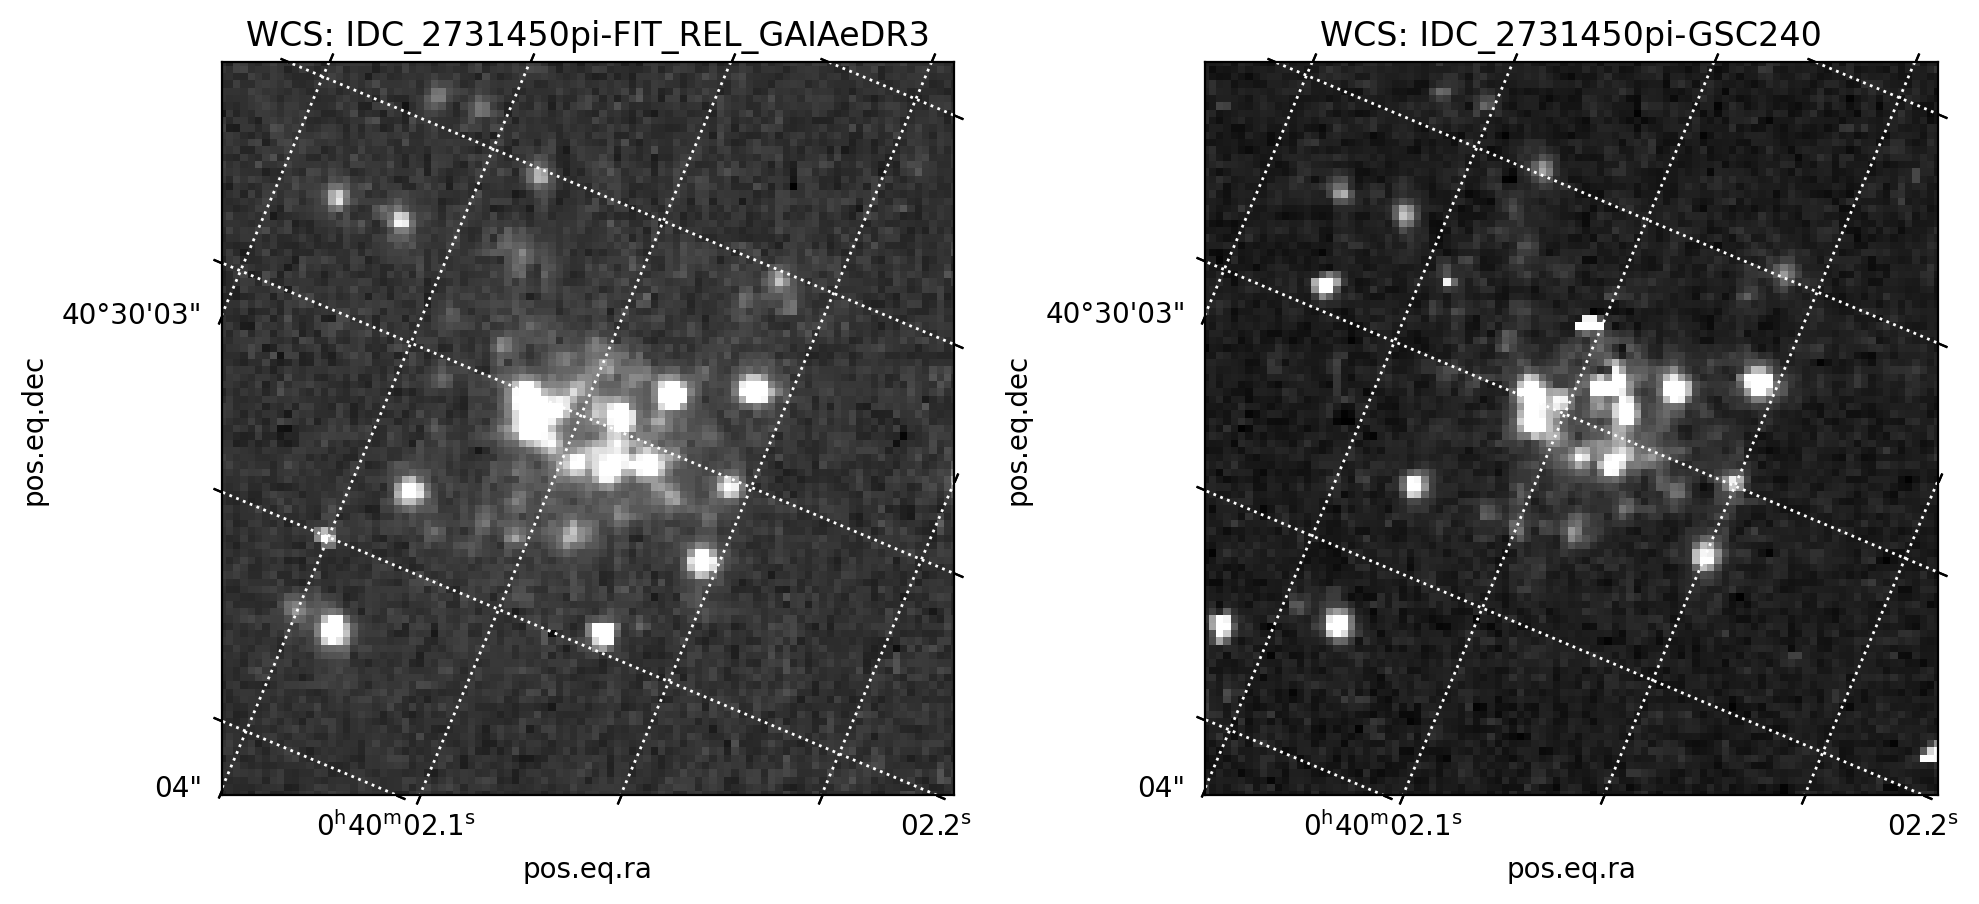

In [34]:
# Display the two science images and zoom in on an object to see the astrometric error.
image1 = 'iepw14030_drc.fits'
image2 = 'iepw14040_drc.fits'

sci_image1 = fits.getdata(image1)
sci_image2 = fits.getdata(image2)
wcs_image1 = WCS(fits.getheader(image1, 1))
wcs_image2 = WCS(fits.getheader(image2, 1))
x1, y1 = wcs_image1.world_to_pixel_values([center])[0].astype(int)
x2, y2 = wcs_image2.world_to_pixel_values([center])[0].astype(int)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 2, 1, projection=wcs_image1)
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_image2)

ax1.set_title('WCS: '+fits.getval(image1, 'WCSNAME', ext=('SCI', 1)))
ax2.set_title('WCS: '+fits.getval(image2, 'WCSNAME', ext=('SCI', 1)))
ax1.imshow(sci_image1, vmin=z.get_limits(sci_image1)[0], vmax=z.get_limits(sci_image1)[1]*5, cmap='Greys_r', origin='lower', interpolation='none')
ax2.imshow(sci_image2, vmin=z.get_limits(sci_image2)[0], vmax=z.get_limits(sci_image2)[1]*5, cmap='Greys_r', origin='lower', interpolation='none')

ax1.set_xlim(x1-50, x1+50)
ax1.set_ylim(y1-50, y1+50)
ax2.set_xlim(x2-50, x2+50)
ax2.set_ylim(y2-50, y2+50)
ax1.grid(lw=1, color='white', ls=':')
ax2.grid(lw=1, color='white', ls=':')
plt.tight_layout()

Here we see a small misalignment between the two filters in the pipeline drizzled files which have different WCS solutions. <br>
<br>
Finally, we  display the redrizzled image which uses the improved FIT-SVM-GAIAeDR3 WCS, which restores the alignment.

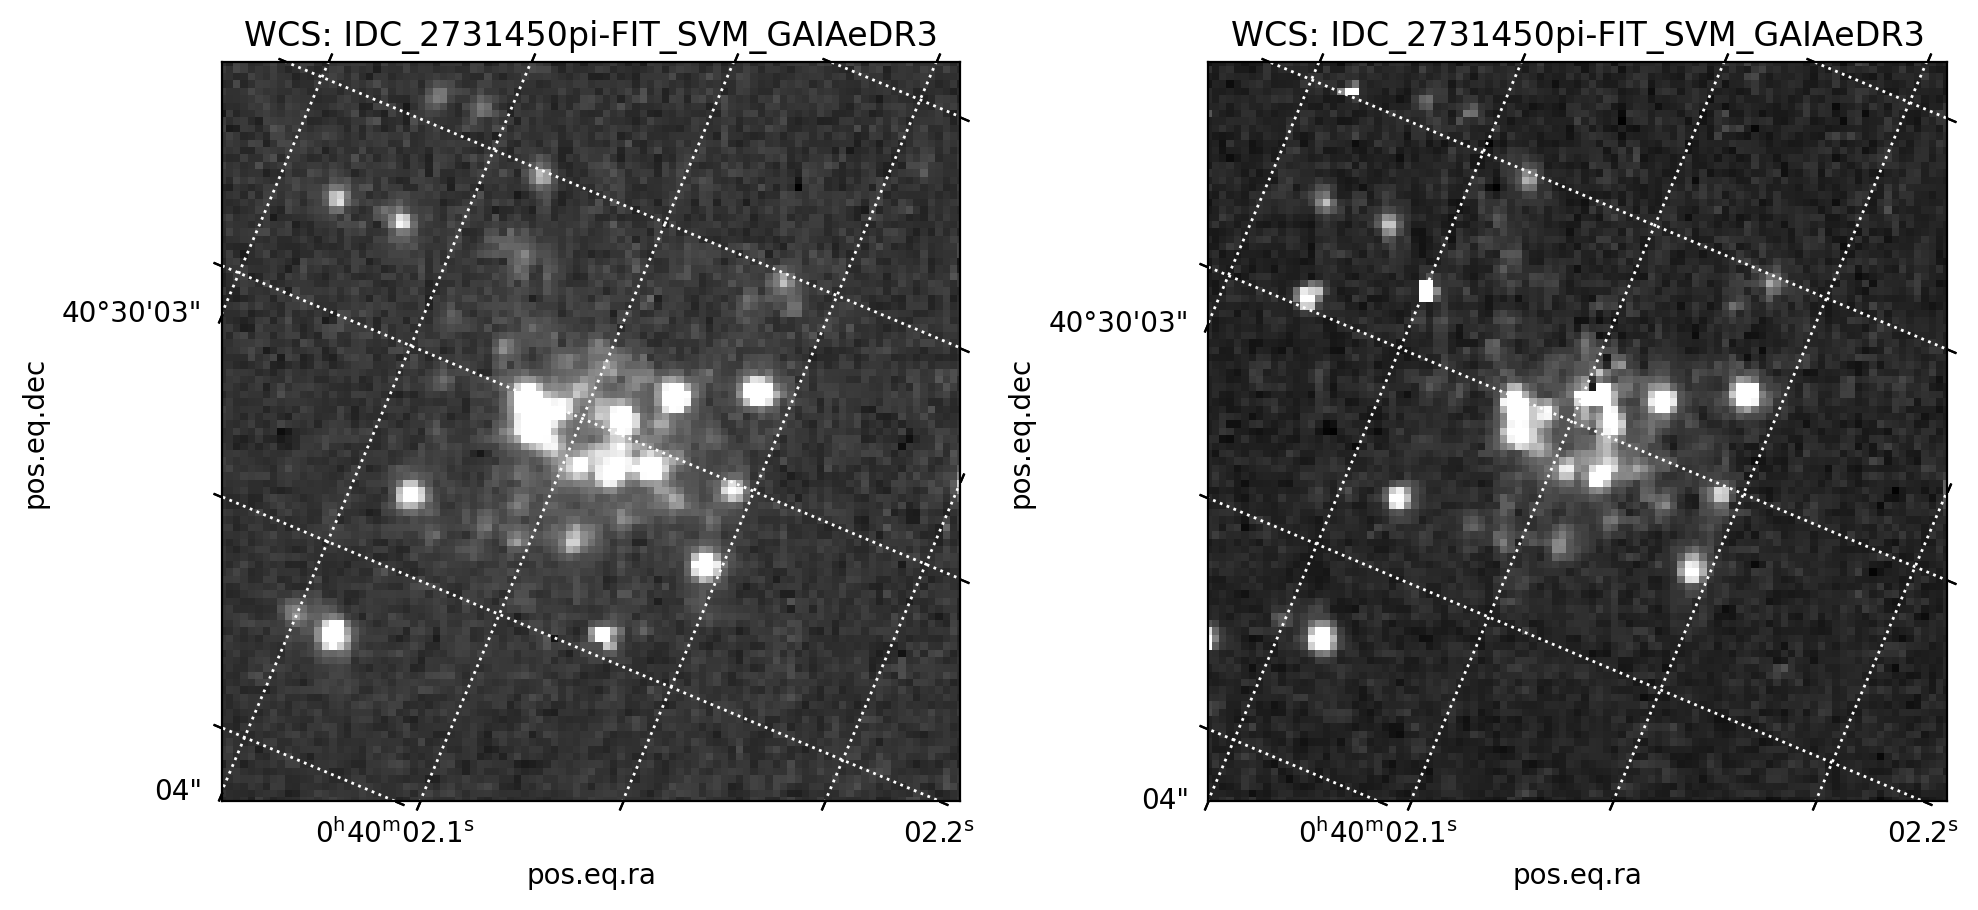

In [35]:
# Display the two science images and zoom in on an object to see the astrometric error.
image1 = 'iepw14030_updated_wcs_drc.fits'
image2 = 'iepw14040_updated_wcs_drc.fits'

sci_image1 = fits.getdata(image1)
sci_image2 = fits.getdata(image2)
wcs_image1 = WCS(fits.getheader(image1, 1))
wcs_image2 = WCS(fits.getheader(image2, 1))
x1, y1 = wcs_image1.world_to_pixel_values([center])[0].astype(int)
x2, y2 = wcs_image2.world_to_pixel_values([center])[0].astype(int)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 2, 1, projection=wcs_image1)
ax2 = fig.add_subplot(1, 2, 2, projection=wcs_image2)

ax1.set_title('WCS: '+fits.getval(image1, 'WCSNAME', ext=('SCI', 1)))
ax2.set_title('WCS: '+fits.getval(image2, 'WCSNAME', ext=('SCI', 1)))
ax1.imshow(sci_image1, vmin=z.get_limits(sci_image1)[0], vmax=z.get_limits(sci_image1)[1]*5, cmap='Greys_r', origin='lower', interpolation='none')
ax2.imshow(sci_image2, vmin=z.get_limits(sci_image2)[0], vmax=z.get_limits(sci_image2)[1]*5, cmap='Greys_r', origin='lower', interpolation='none')

ax1.set_xlim(x1-50, x1+50)
ax1.set_ylim(y1-50, y1+50)
ax2.set_xlim(x2-50, x2+50)
ax2.set_ylim(y2-50, y2+50)
ax1.grid(lw=1, color='white', ls=':')
ax2.grid(lw=1, color='white', ls=':')
plt.tight_layout()

<a id="conclude"></a>
## Conclusions

[Table of Contents](#toc)

This notebook demonstrates how to access and apply different WCS solutions from exposure and SVM headerlets. In general, it is always preferred to have consistent WCS solutions across exposures, especially from the same visit. Users can also custom align their exposures to one another, as well as to external catalogs such as SDSS and Gaia. This process is detailed in the [align_to_catalogs](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/DrizzlePac/align_to_catalogs/align_to_catalogs.ipynb) notebook.

<a id="about"></a>
## About this Notebook
    
    Created: 14 Dec 2018;     V. Bajaj
    Updated: 31 May 2024;     M. Revalski, V. Bajaj, & J. Mack

**Source:** GitHub [spacetelescope/hst_notebooks](https://github.com/spacetelescope/hst_notebooks)

<a id="add"></a>
## Additional Resources

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst), selecting the DrizzlePac category.

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)

<a id="cite"></a>
## Citations
If you use Python packages such as `astropy`, `astroquery`, `drizzlepac`, `matplotlib`, or `numpy` for published research, please cite the authors.

Follow these links for more information about citing various packages:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `drizzlepac`](https://zenodo.org/records/3743274)
* [Citing `matplotlib`](https://matplotlib.org/stable/users/project/citing.html)
* [Citing `numpy`](https://numpy.org/citing-numpy/)
***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 